# Modelling and Predicting Employee Attrition #

In [1]:
library(tidyverse)
library(broom)
library(GGally)
library(car)
library(glmnet)
library(caret)
library(repr)
library(infer)
library(gridExtra)
library(pROC)
library(boot)
install.packages("ROSE")
options(warn = -1)
library(ROSE)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8

Loading required package: latti

## STAT 301: Group Project

#### Names: Justin Bourdon, Nour Abdelfattah, Nav Thukral, Sean Lin

#### Student Numbers: 13755392, 97158414, 20761581, 79391983

## Introduction

The HR Analytics dataset mainly focuses on data related to the trend of employees. The dataset contains 1470 observations, and for each observation, we have 35 variables, as shown below (Age, Attrition, BusinessTravel, etc.). Attrition is a commonly noted challenge faced by many companies and corporations. To face this challenge, we can use machine learning models in order to predict potential attrition cases. This solution allows managers to better prepare and generate business strategies that would promote employee retention. 

As for the question we plan on answering, we looked through the variables given and determined that three seemingly relevant variables were JobSatisfaction, YearsAtCompany, and MonthlyIncome. Along with our binary response variable "Attrition", our question becomes:

**"Do job satisfaction, monthly income, and total working years at a company affect employee attrition, and can we predict which employees are more likely to elave the company based on these variables"**

In [192]:
# Download latest version
path = "HR-Employee-Attrition 2.csv"

raw_data=read_csv(path)

head(raw_data)

Rows: 1470 Columns: 35
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): Attrition, BusinessTravel, Department, EducationField, Gender, Job...
dbl (26): Age, DailyRate, DistanceFromHome, Education, EmployeeCount, Employ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,⋯,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,⋯,1,80,0,8,0,1,6,4,0,5
49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,⋯,4,80,1,10,3,3,10,7,1,7
37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,⋯,2,80,0,7,3,3,0,0,0,0
33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,⋯,3,80,0,8,3,3,8,7,3,0
27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,⋯,4,80,1,6,3,3,2,2,2,2
32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,⋯,3,80,0,8,2,2,7,7,3,6


## Methods and Results ## 

### 1) Exploratory Data Analysis

To better understand the relationship between the explanatory variables (`MonthlyIncome`, `YearsAtCompany`, `JobSatisfaction`) and the response variable (`Attrition`), we performed the following exploratory data analysis:
1. Examined the distribution of `MonthlyIncome`.
2. Visualized the relationship between `Attrition` and each explanatory variable using bar plots and box plots.
3. Explored pairwise relationships between variables with `ggpairs`.

These visualizations provide insights into potential patterns and associations that could influence attrition.

### Dataset Summary

| Variable                | Description                                                    | Type               |
|-------------------------|----------------------------------------------------------------|--------------------|
| Age                     | Age of the employee                                           | Continuous        |
| Attrition               | Employee attrition, whether or not they leave the company     | Binary |
| BusinessTravel          | How frequently an employee travels for business purposes       | Categorical       |
| DailyRate               | Daily wage of an employee                                     | Continuous        |
| Department              | Employee's department                                           | Categorical       |
| DistanceFromHome        | Distance from home to office in KM's                          | Continuous        |
| Education               | Qualification of employee                                     | Continuous        |
| EducationField          | Stream of Education                                           | Categorical       |
| EmployeeCount           | Employee count (1 employee per observation, so max = 1)      | Continuous        |
| EmployeeNumber          | Employee number                                               | Continuous        |
| EnvironmentSatisfaction | Level of employee satisfaction with environment               |Categorical/Ordinal |
| Gender                  | Gender of employee                                            | Binary |
| HourlyRate              | Employee hourly rate                                          | Continuous        |
| JobInvolvement          | Job involvement                                               | Categorical/Ordinal|
| JobLevel                | Level of Job                                                  | Continuous        |
| JobRole                 | Job role of an employee                                       | Categorical       |
| JobSatisfaction         | If employee is satisfied?                                     | Categorical/Ordinal |
| MaritalStatus           | If employee is married or not?                                | Categorical       |
| MonthlyIncome           | Income of an employee per month                               | Continuous        |
| MonthlyRate             | Monthly rate of an employee                                   | Continuous        |
| NumCompaniesWorked      | Number of companies worked for                                | Continuous        |
| Over18                  | If they are over the age of 18                                | Binary |
| OverTime                | Does employee work overtime?                                  | Binary |
| PercentSalaryHike       | Salary hike in percentage (%)                                 | Continuous        |
| PerformanceRating       | Performance rate                                              | Continuous        |
| RelationshipSatisfaction| Relationship satisfaction                                     | Categorical/Ordinal |
| StandardHours           | Per week standard work hours                                  | Continuous        |
| StockOptionLevel        | Company stock option level                                    | Continuous        |
| TotalWorkingYears       | Total years working                                           | Continuous        |
| TrainingTimesLastYear   | Training time in the last year                                | Continuous        |
| WorkLifeBalance         | Work-life balance                                             | Categorical/Ordinal  |
| YearsAtCompany          | Total years at current company                                | Continuous        |
| YearsInCurrentRole      | Total years in current role                                   | Continuous        |
| YearsSinceLastPromotion | Years since last promotion                                    | Continuous        |
| YearsWithCurrManager    | Years worked under current manager                            | Continuous        |

Before we start visualizing our variables of interest, we can clean our data and observe what types of variables our dataset contains. Just by a scan of the dataset, we see three columns that are redundant, as they only have one value across all the datapoints. These columns are `EmployeeCount`, `StandardHours`, and `Over18`. 

In [201]:
data <- raw_data %>% select(-EmployeeCount, -StandardHours, -Over18)

In [202]:
#checking dataset dimensions
shape <- dim(data)
shape

[1] 1470   32

Next, we can look at our categorical variables and see what different categories they contain

In [204]:
data %>%
  select_if(is.character) %>%
  map(unique)

$Attrition
[1] "Yes" "No" 

$BusinessTravel
[1] "Travel_Rarely"     "Travel_Frequently" "Non-Travel"       

$Department
[1] "Sales"                  "Research & Development" "Human Resources"       

$EducationField
[1] "Life Sciences"    "Other"            "Medical"          "Marketing"       
[5] "Technical Degree" "Human Resources" 

$Gender
[1] "Female" "Male"  

$JobRole
[1] "Sales Executive"           "Research Scientist"       
[3] "Laboratory Technician"     "Manufacturing Director"   
[5] "Healthcare Representative" "Manager"                  
[7] "Sales Representative"      "Research Director"        
[9] "Human Resources"          

$MaritalStatus
[1] "Single"   "Married"  "Divorced"

$OverTime
[1] "Yes" "No"

As seen by the code below, there are no missing values, which makes our job of cleaning values a lot easier

In [5]:
colSums(is.na(data))

Age                Attrition           BusinessTravel 
                       0                        0                        0 
               DailyRate               Department         DistanceFromHome 
                       0                        0                        0 
               Education           EducationField           EmployeeNumber 
                       0                        0                        0 
 EnvironmentSatisfaction                   Gender               HourlyRate 
                       0                        0                        0 
          JobInvolvement                 JobLevel                  JobRole 
                       0                        0                        0 
         JobSatisfaction            MaritalStatus            MonthlyIncome 
                       0                        0                        0 
             MonthlyRate       NumCompaniesWorked                 OverTime 
                       0                        0                        0 
       PercentSalaryHike        PerformanceRating RelationshipSatisfaction 
                       0                        0                        0 
        StockOptionLevel        TotalWorkingYears    TrainingTimesLastYear 
                       0                        0                        0 
         WorkLifeBalance           YearsAtCompany       YearsInCurrentRole 
                       0                        0                        0 
 YearsSinceLastPromotion     YearsWithCurrManager 
                       0                        0

With the data cleaned, we can summarize all the columns and see some statistics of the values

In [206]:
summary(data)

      Age         Attrition         BusinessTravel       DailyRate     
 Min.   :18.00   Length:1470        Length:1470        Min.   : 102.0  
 1st Qu.:30.00   Class :character   Class :character   1st Qu.: 465.0  
 Median :36.00   Mode  :character   Mode  :character   Median : 802.0  
 Mean   :36.92                                         Mean   : 802.5  
 3rd Qu.:43.00                                         3rd Qu.:1157.0  
 Max.   :60.00                                         Max.   :1499.0  
  Department        DistanceFromHome   Education     EducationField    
 Length:1470        Min.   : 1.000   Min.   :1.000   Length:1470       
 Class :character   1st Qu.: 2.000   1st Qu.:2.000   Class :character  
 Mode  :character   Median : 7.000   Median :3.000   Mode  :character  
                    Mean   : 9.193   Mean   :2.913                     
                    3rd Qu.:14.000   3rd Qu.:4.000                     
                    Max.   :29.000   Max.   :5.000              

Since our question is only focused on the variables "JobSatisfaction", "YearsAtCompany", and "MonthlyIncome", we can select only these variables in our data

In [208]:
data <- data %>%
    select(
        # response variable
        Attrition,
        # explanatory variables
        JobSatisfaction,
        YearsAtCompany,
        MonthlyIncome)

head(data)

Attrition,JobSatisfaction,YearsAtCompany,MonthlyIncome
<chr>,<dbl>,<dbl>,<dbl>
Yes,4,6,5993
No,2,10,5130
Yes,3,0,2090
No,3,8,2909
No,2,2,3468
No,4,7,3068


In [209]:
# visualizing summary statistics for our desired variables 

numerical_stats <- data %>%
    select_if(is.numeric) %>%
    gather(factor_key = TRUE, key = 'variable', value = 'value') %>%
    group_by(variable) %>%
    summarise(mean = mean(value),
              sd = sd(value), 
              max = max(value), 
              min = min(value)) %>%
    mutate_if(is.numeric, round, 2)

numerical_stats

categorical_stats <- data %>%
    select_if(is.character) %>% 
    gather(key = "variable", value = "level") %>%
    group_by(variable, level) %>%
    summarise(count = n(), .groups = 'drop') %>%
    group_by(variable) %>%
    mutate(percentage = round((count / sum(count)) * 100, 2))

categorical_stats


variable,mean,sd,max,min
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
JobSatisfaction,2.73,1.10,4,1
YearsAtCompany,7.01,6.13,40,0
MonthlyIncome,6502.93,4707.96,19999,1009


variable,level,count,percentage
<chr>,<chr>,<int>,<dbl>
Attrition,No,1233,83.88
Attrition,Yes,237,16.12


Important NOTE: `JobSatisfaction is an ordinal variable so will be used as a factor in our logistic regression model

### Distribution of Employee Monthly Incomes
The histogram shows the distribution of employee monthly incomes. Most employees fall within a specific income range, with a few outliers at the higher end. This distribution will help us understand how income might relate to attrition.

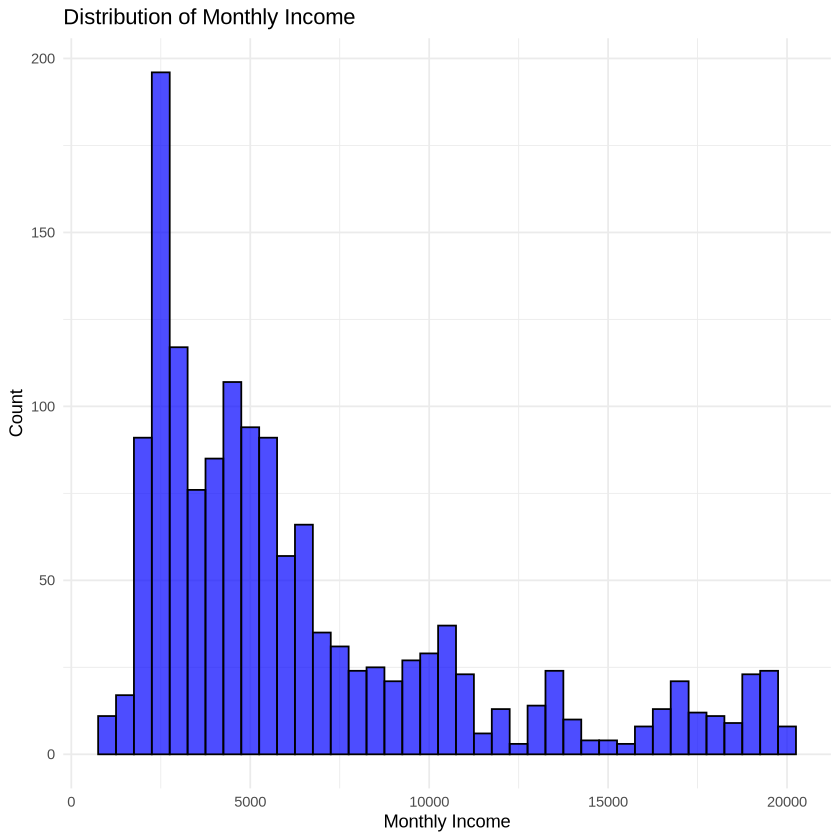

In [8]:
# Histogram of MonthlyIncome
library(ggplot2)

ggplot(data, aes(x = MonthlyIncome)) +
  geom_histogram(binwidth = 500, fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Distribution of Monthly Income", x = "Monthly Income", y = "Count") +
  theme_minimal()


###  Years at the Company by Attrition
The bar plot indicates that employees with fewer years at the company are more likely to leave (higher attrition rates). Attrition seems to decrease as tenure increases, suggesting longer-tenured employees are more likely to stay.

We can also visualize the plot using a fill position, and we notice that from 0-20 years at the company, there seems to be a trend that suggests that as the longer someone works at a company, the less likely they are to leave. As we reach the higher end however, we notice some inconsistent values, and this most likely stems from the lack of data points that have YearsAtCompany>25. 

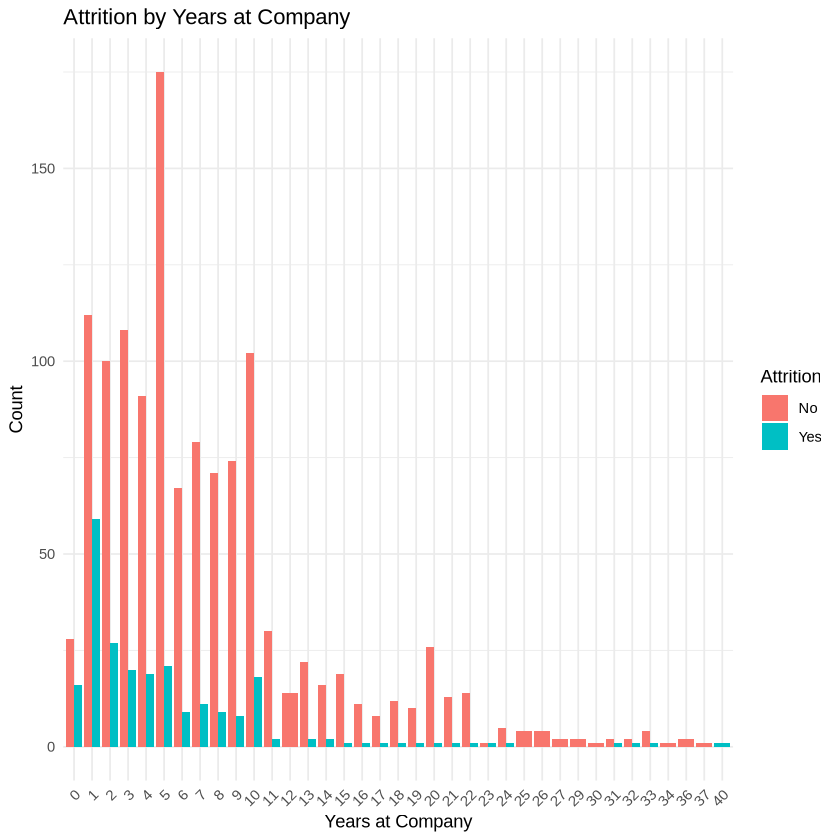

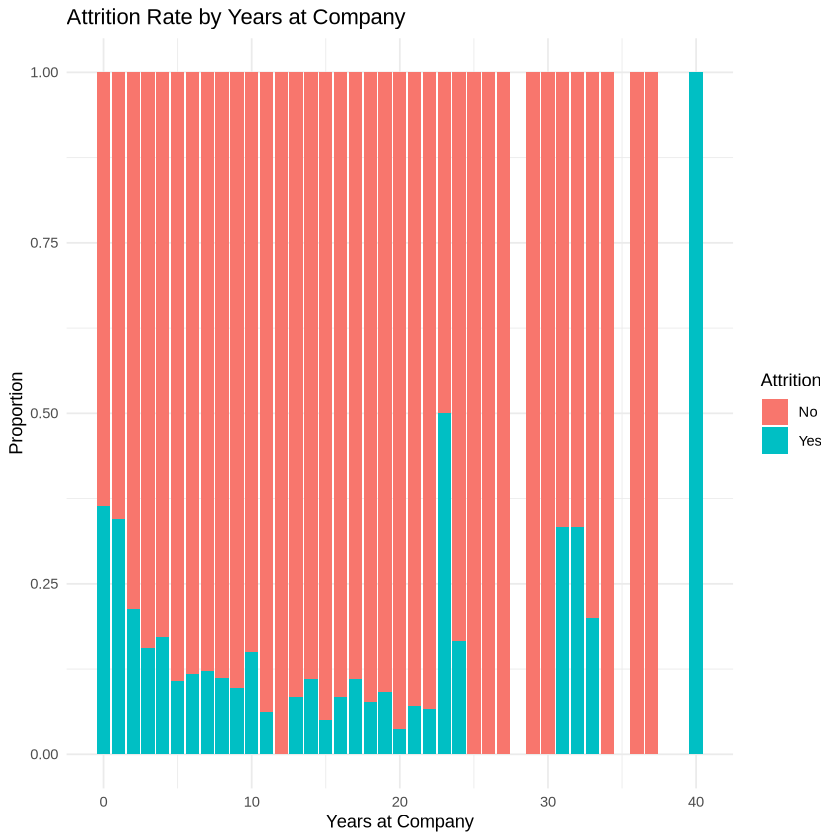

In [215]:
# Bar plot (dodge) of Attrition by YearsAtCompany
ggplot(data, aes(x = factor(YearsAtCompany), fill = Attrition)) +
  geom_bar(position = "dodge") +
  labs(title = "Attrition by Years at Company", x = "Years at Company", y = "Count", fill = "Attrition") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# bar plot (fill) of attrition by years at company
ggplot(data, aes(x = YearsAtCompany, fill = Attrition)) +
    geom_bar(position = "fill") + 
    labs(
        title = "Attrition Rate by Years at Company",
        x = "Years at Company",
        y = "Proportion"
    ) +
    theme_minimal()

### Monthly Income by Attrition

The boxplot illustrates the relationship between monthly income and employee attrition. Employees who left the company (`Attrition = Yes`) tend to have a lower median monthly income compared to those who stayed (`Attrition = No`). This suggests that lower income may be a contributing factor to attrition, with a noticeable disparity between the two groups. Outliers are present in both categories, indicating that some employees with higher incomes still left the organization, highlighting the potential influence of additional factors.

We can also revisualize the relationship with a histogram. We notice that although there a lot more data points at the lower end, we still notice that as the monthly income increases, there is a decrease in attrition rates on average. 

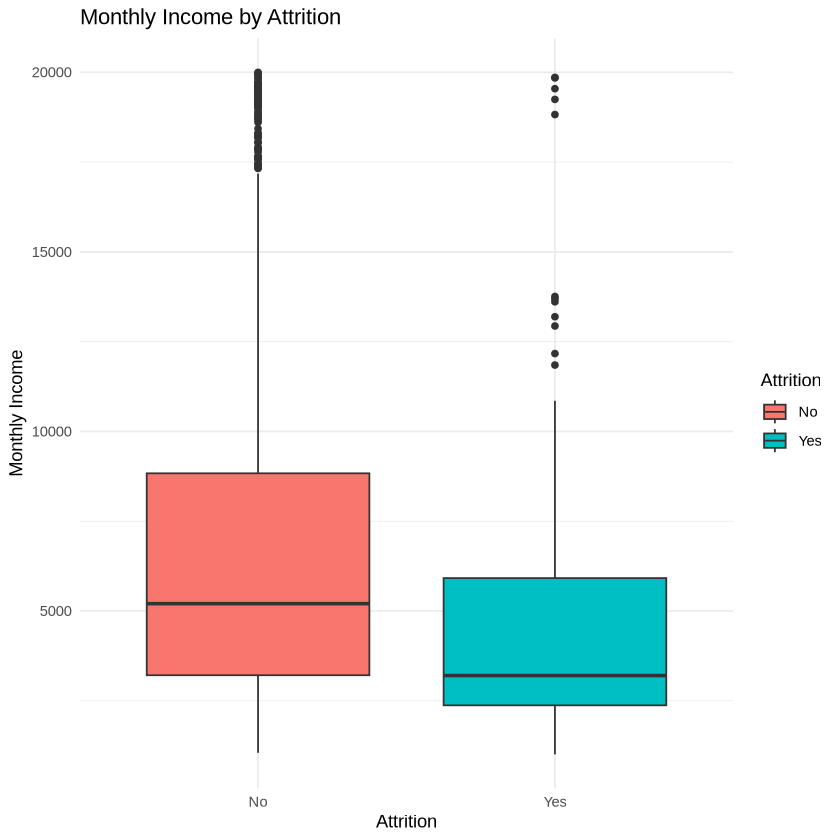

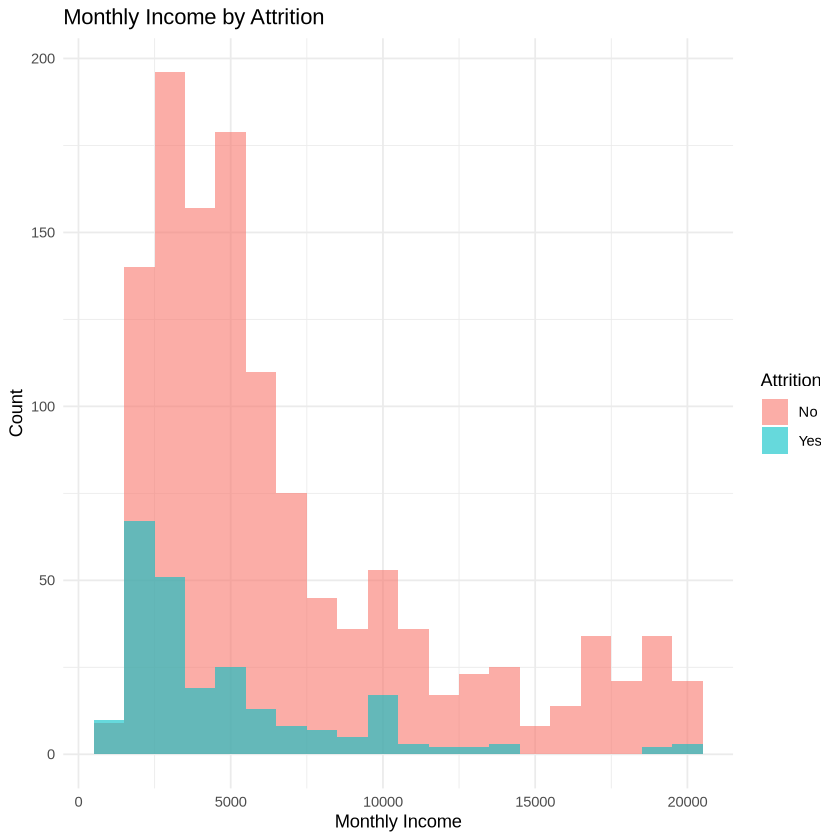

In [10]:
# Boxplot of MonthlyIncome by Attrition
ggplot(data, aes(x = Attrition, y = MonthlyIncome, fill = Attrition)) +
  geom_boxplot() +
  labs(title = "Monthly Income by Attrition", x = "Attrition", y = "Monthly Income") +
  theme_minimal()

# histogram of monthly income by attrition
ggplot(data, aes(x = MonthlyIncome, fill = Attrition)) +
  geom_histogram(position = "identity", binwidth = 1000, alpha=0.6) +
  labs(
    title = "Monthly Income by Attrition",
    x = "Monthly Income",
    y = "Count"
  ) +
  theme_minimal()

### Job Satisfaction by Attrition

The barplot below displays the relationship between job satisfaction and attrition. The barplot is made with the position "fill" so that we can see the proportion distribution of the job satisfaction level and the attrition rate. The "yes" value of attrition is shown in blue and "no" is shown in red. As we can see, as the value of job satisfaction increases, the likelihood of attrition decreases by a noticable amount. There seems to be a linear relationship between the variables.

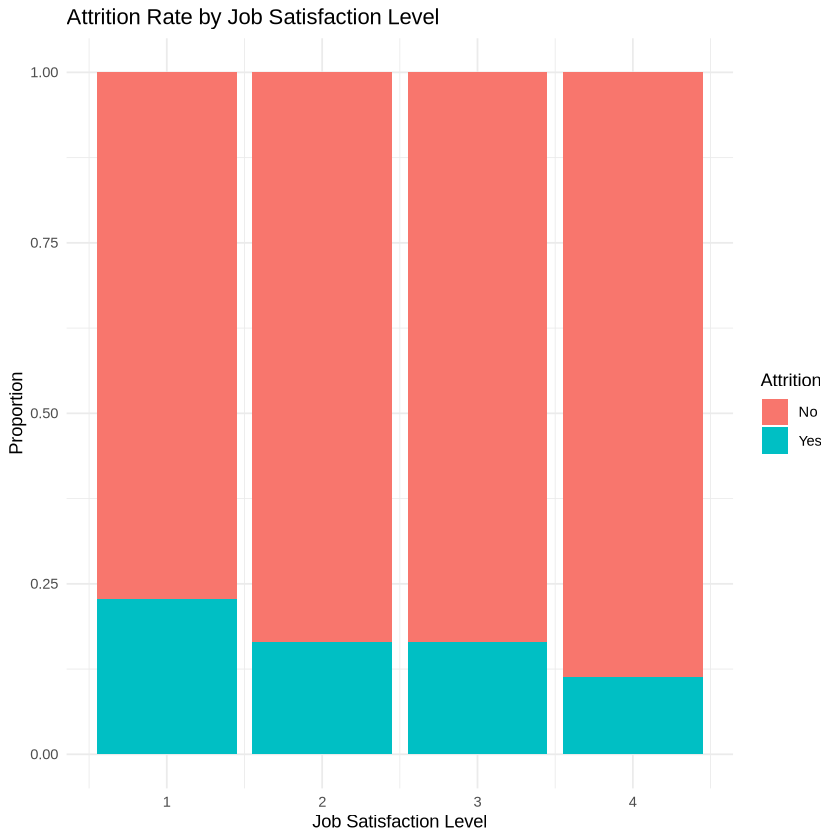

In [11]:
# barplot of job satisfaction by attrition
ggplot(data, aes(x = JobSatisfaction, fill = Attrition)) +
    geom_bar(position = "fill") + 
    labs(
        title = "Attrition Rate by Job Satisfaction Level",
        x = "Job Satisfaction Level",
        y = "Proportion"
    ) +
    theme_minimal()

### Pairwise Relationships Between Variables

The pairwise plot provides an overview of the relationships between `MonthlyIncome`, `YearsAtCompany`, and `Attrition`. From the visualizations:
- A moderate positive correlation (0.514) is observed between `MonthlyIncome` and `YearsAtCompany`, suggesting that longer tenure is generally associated with higher income.
- Employees with `Attrition = No` have slightly higher median values for both `MonthlyIncome` and `YearsAtCompany`, as shown in the box plots.
- The distributions and scatterplots highlight differences between employees who stayed (`Attrition = No`) and those who left (`Attrition = Yes`), offering insights into the predictors of attrition.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


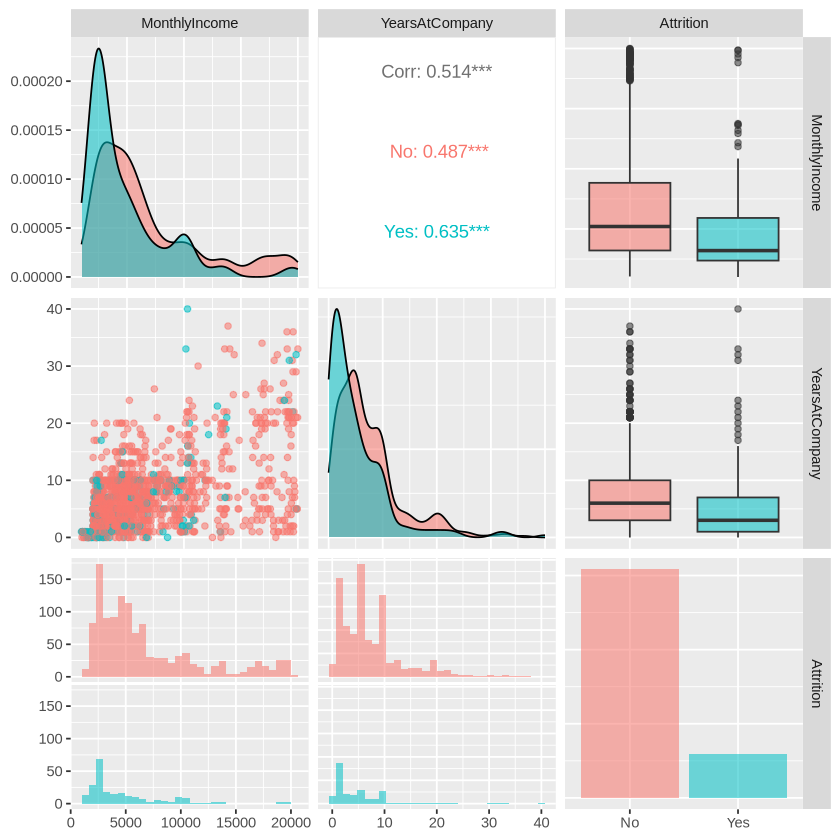

In [12]:
# Select relevant columns for pairwise relationships
eda_data <- data %>% 
  select(MonthlyIncome, YearsAtCompany, Attrition)

# Create pairwise plot
ggpairs(eda_data, aes(color = Attrition, alpha = 0.7))



### 2) Methods: Plan ###

In [193]:
attrition_data <- data

attrition_data <- attrition_data %>%
  mutate(
    JobSatisfaction = as.factor(JobSatisfaction),
    Attrition = if_else(Attrition == "Yes", 1, 0) 
  )

table(attrition_data$Attrition)


   0    1 
1233  237 

In [194]:
set.seed(123)

attrition_data <- attrition_data %>%
  mutate(ID = row_number())

#training set
attrition_data_train <- 
    attrition_data %>% 
    slice_sample(prop = 0.70)

#test set 
attrition_data_test <- 
    attrition_data %>% 
    anti_join(attrition_data_train, by = "ID")

cat("Training Set Class Distribution:\n")
print(table(attrition_data_train$Attrition))

cat("\nTest Set Class Distribution:\n")
print(table(attrition_data_test$Attrition))

#oversampling minority class in training set to adjust class imbalance issue
balanced_data_train <- ovun.sample(
    Attrition ~ ., 
    data = attrition_data_train, 
    method = "both", 
    p = 0.3 # Proportion of the minority class you (30%)
)$data

cat("\nBalanced Training Set Class Distribution:\n")
table(balanced_data_train$Attrition)

attrition_data_train <- balanced_data_train  %>% select(-ID)
attrition_data_test <- attrition_data_test  %>% select(-ID)

Training Set Class Distribution:

  0   1 
867 162 

Test Set Class Distribution:

  0   1 
366  75 

Balanced Training Set Class Distribution:



  0   1 
726 303 

In [195]:
#additive model 
logistic_model <- 
    glm(
        formula = Attrition ~ MonthlyIncome + YearsAtCompany + JobSatisfaction,
        data = attrition_data_train,
        family = binomial)

# 10-fold cross-validation
cv_results <- cv.glm(
    data = attrition_data_train, 
    glmfit = logistic_model,
    K = 10
)

# cross-validated error
print(cv_results$delta[1])  # Cross-validation errors


[1] 0.1882144


In [197]:
#predict attrition class on test set
pred_probs <- 
  predict(logistic_model, newdata = attrition_data_test, type = "response")

pred_classes <- ifelse(pred_probs >= 0.5, 1, 0)

#illustarte results in confusion matrix
attrition_data_confusion_matrix <- 
    confusionMatrix(
    data = as.factor(pred_classes),
    reference = as.factor(attrition_data_test$Attrition),
    positive = '1'
)


attrition_data_confusion_matrix

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 345  65
         1  21  10
                                          
               Accuracy : 0.805           
                 95% CI : (0.7649, 0.8409)
    No Information Rate : 0.8299          
    P-Value [Acc > NIR] : 0.9255          
                                          
                  Kappa : 0.0991          
                                          
 Mcnemar's Test P-Value : 3.538e-06       
                                          
            Sensitivity : 0.13333         
            Specificity : 0.94262         
         Pos Pred Value : 0.32258         
         Neg Pred Value : 0.84146         
             Prevalence : 0.17007         
         Detection Rate : 0.02268         
   Detection Prevalence : 0.07029         
      Balanced Accuracy : 0.53798         
                                          
       'Positive' Class : 1               
                              

Setting levels: control = 0, case = 1

Setting direction: controls < cases



AUC Value: 0.62 


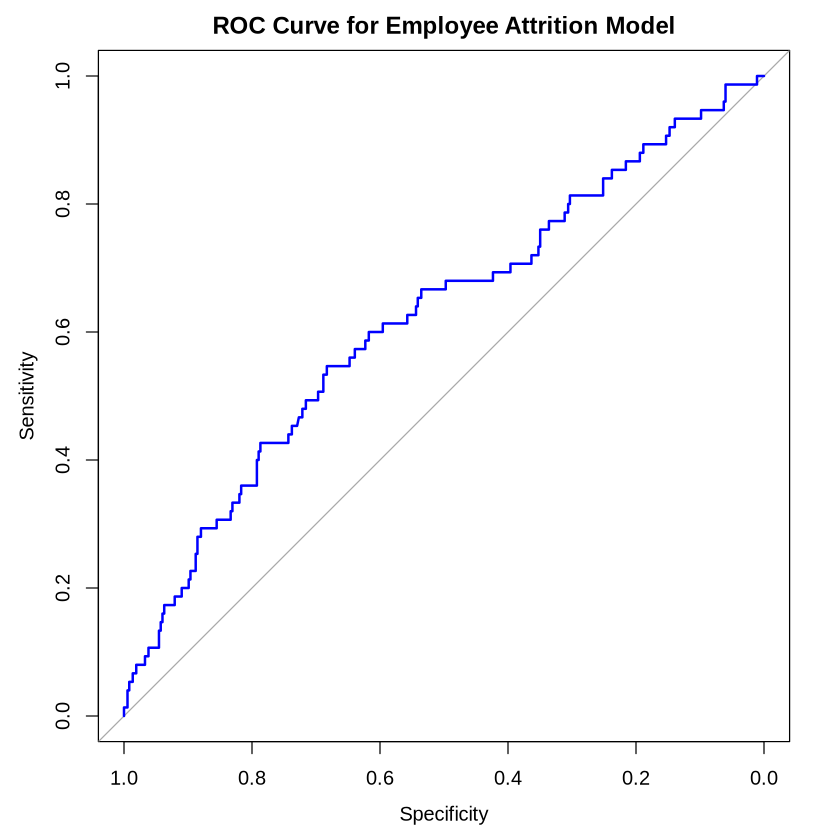

In [198]:
# Generate the ROC curve
roc_curve <- roc(response = attrition_data_test$Attrition, 
                 predictor = pred_probs)

# Plot the ROC curve
plot(roc_curve, 
     main = "ROC Curve for Employee Attrition Model", 
     col = "blue", 
     lwd = 2)

# Add AUC to the plot
auc_value <- auc(roc_curve)
cat("AUC Value:", round(auc_value, 2), "\n")


In [213]:
#interpretation for AUC score goes here 

By Oversampling the minority class (Yes) in the training set, our model shows some correct predictions of the positive class but nonetheless, the real, unaltered test data still has a prominent class imbalance. Since our majority class = 0 (No attrition), another metric we can use to assess model performance is:

**Specificity ($\text{SP}$):** the number of **correct** failure predictions divided by the total number of real failures ($\text{F}$). In other words, it is the estimated probability of predicting 0 given that the true class is 0.

We know that the total number of real failures in the test set = 366 (see table above) and the model successfully predicted 345 (see confusion matrix). **This means that our specificity score is:**

In [211]:
345 / 366

[1] 0.942623

Thus, our model shows 94.3% accuracy for predicting the majority class (No attrition).

## Discussion ##

## References ## 

Fallucchi, F., Coladangelo, M., Giuliano, R., & William De Luca, E. (2020). Predicting employee attrition using machine learning techniques. Computers, 9(4), 86.

